# Using Qiskit Runtime with session and primitives

**Qiskit Runtime** is a quantum computing service and programming model that allows our users to optimize workloads and efficiently execute them on quantum systems at scale.

**Primitives** are core functions that make it easier to build modular algorithms and applications. 

Instead of simply returning counts, they return more immediately meaningful information. 

Additionally, they provide a seamless way to access the latest advancements in IBM Quantum hardware and software.

**Sampler:** Generates quasi-probabilities from input circuits.

**Estimator:** Calculates expectation values from input circuits and observables.

## Using the Estimator primitive

### 1. Create a circuit

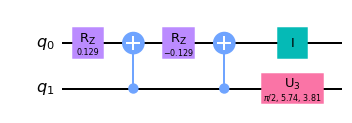

In [1]:
from qiskit.circuit.random import random_circuit

circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
display(circuit.draw("mpl"))

### 2. Create an observable to measure

In [2]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp("XZ")
print(f">>> Observable: {observable.paulis}")

>>> Observable: ['XZ']


### 3. Initialize an Estimator class

In [3]:
from qiskit.primitives import Estimator

estimator = Estimator()

### 4. Invoke the Estimator and get results

In [4]:
job = estimator.run(circuit, observable)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: c23d3676-ce12-4a40-bf44-758ec6b11a04
>>> Job Status: JobStatus.DONE


In [5]:
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")

>>> EstimatorResult(values=array([0.85347811]), metadata=[{}])
  > Expectation value: 0.8534781134132173


You can keep invoking the `run()` method again with the different inputs:

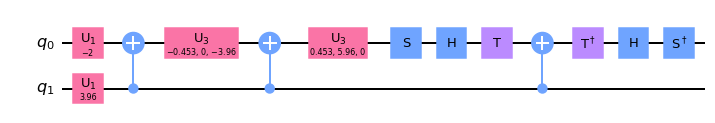

>>> Observable: ['IY']
>>> Expectation value: -1.582539029327245e-16


In [6]:
circuit = random_circuit(2, 2, seed=1).decompose(reps=1)
observable = SparsePauliOp("IY")

job = estimator.run(circuit, observable)
result = job.result()

display(circuit.draw("mpl"))
print(f">>> Observable: {observable.paulis}")
print(f">>> Expectation value: {result.values[0]}")

You can also provide compound inputs to the `run()` method:

In [8]:
circuits = (
    random_circuit(2, 2, seed=0).decompose(reps=1),
    random_circuit(2, 2, seed=1).decompose(reps=1),
)
observables = (
    SparsePauliOp("XZ"),
    SparsePauliOp("IY"),
)

job = estimator.run(circuits, observables)
result = job.result()

print(f">>> Expectation values: {result.values.tolist()}")

>>> Expectation values: [0.8534781134132173, -1.582539029327245e-16]


Or use parameterized circuits:

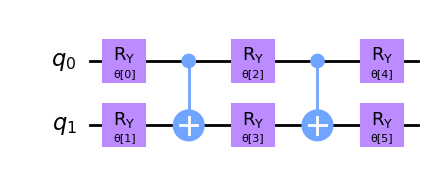

>>> Observable: ['ZI']
>>> Parameter values: [0, 1, 2, 3, 4, 5]
>>> Expectation value: -0.6485568434766461


In [8]:
from qiskit.circuit.library import RealAmplitudes

circuit = RealAmplitudes(num_qubits=2, reps=2).decompose(reps=1)
observable = SparsePauliOp("ZI")
parameter_values = [0, 1, 2, 3, 4, 5]

job = estimator.run(circuit, observable, parameter_values)
result = job.result()

display(circuit.draw("mpl"))
print(f">>> Observable: {observable.paulis}")
print(f">>> Parameter values: {parameter_values}")
print(f">>> Expectation value: {result.values[0]}")

## Using Qiskit Runtime Estimator

### 1. Initialize account

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_API_TOKEN") was used to save account.

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

### 2. Create a circuit and an observable

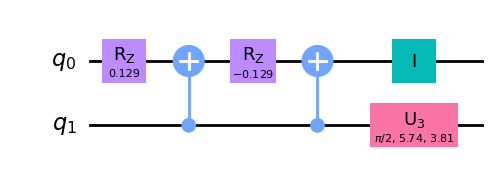

>>> Observable: ['XZ']


In [10]:
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp

circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
display(circuit.draw("mpl"))

observable = SparsePauliOp("XZ")
print(f">>> Observable: {observable.paulis}")

### 3. Initialize the Qiskit Runtime Estimator

In [11]:
from qiskit_ibm_runtime import Estimator

estimator = Estimator(session=backend)

### 4. Invoke the Estimator and get results

In [12]:
job = estimator.run(circuit, observable)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cdk1j0hg1234sbmpr5vg
>>> Job Status: JobStatus.RUNNING


In [13]:
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

>>> EstimatorResult(values=array([0.8515]), metadata=[{'variance': 0.27494774999999994, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}])
  > Expectation value: 0.8515
  > Metadata: {'variance': 0.27494774999999994, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}


## Options

Primitives come with a number of options that are grouped into different categories. Commonly used options, such as `resilience_level`, are at the first level.

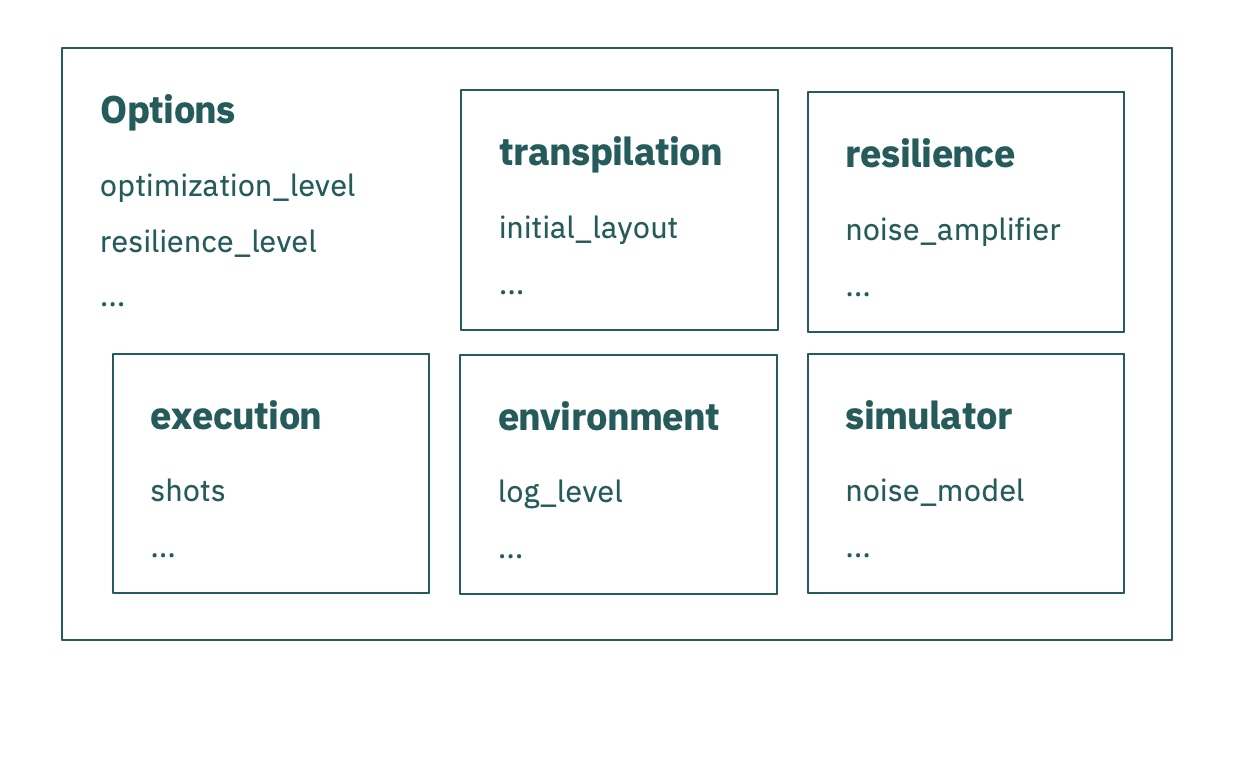

You can use the `Options` class to specify different options.

In [14]:
from qiskit_ibm_runtime import Options

options = Options(optimization_level=3, environment={"log_level": "INFO"})

`Options` supports auto-complete:

In [15]:
from qiskit_ibm_runtime import Options

options = Options()
options.resilience_level = 1
options.execution.shots = 2048

Options can be at the primitive level:

In [16]:
estimator = Estimator(session=backend, options=options)
result = estimator.run(circuit, observable).result()
print(f">>> Metadata: {result.metadata[0]}")

>>> Metadata: {'variance': 0.2781639099121094, 'shots': 2048, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}


Or overwrite at the job level:

In [17]:
estimator = Estimator(session=backend, options=options)
result = estimator.run(circuit, observable, shots=1024).result()
print(f">>> Metadata: {result.metadata[0]}")

>>> Metadata: {'variance': 0.2513694763183594, 'shots': 1024, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}


### Error suppression and mitigation

`optimization_level` and `resilience_level` are used to configure error suppression and mitigation.

Advanced mitigation options can be specified under `resilience`.

In [18]:
from qiskit_ibm_runtime import Options

# optimization_level=3 adds dynamical decoupling
# resilience_level=1 adds readout error mitigation
options = Options(optimization_level=3, resilience_level=1)

In [19]:
estimator = Estimator(session=backend, options=options)
result = estimator.run(circuit, observable).result()
print(f">>> Expectation value: {result.values[0]}")
print(f">>> Metadata: {result.metadata[0]}")

>>> Expectation value: 0.854
>>> Metadata: {'variance': 0.27068400000000004, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}


## Session

A Qiskit Runtime **session** allows you to group a collection of iterative calls to the quantum computer. 

A session is started when the first job within the session is started. 

Subsequent jobs within an active session are prioritized by the scheduler, and data used within a session, such as transpiled circuits, is also cached.

### Invoking Estimator.run within a session

In [20]:
from qiskit_ibm_runtime import Session, Estimator

with Session(backend=backend, max_time="1h"):
    estimator = Estimator()

    result = estimator.run(circuit, observable).result()
    print(f">>> Expectation value from the first run: {result.values[0]}")

    result = estimator.run(circuit, observable).result()
    print(f">>> Expectation value from the second run: {result.values[0]}")

>>> Expectation value from the first run: 0.838
>>> Expectation value from the second run: 0.855


### Invoke multiple primitives in a session

In [22]:
from qiskit_ibm_runtime import Session, Sampler, Estimator

with Session(backend=backend):
    sampler = Sampler()
    estimator = Estimator()

    result = sampler.run(sampler_circuit).result()
    print(f">>> Quasi Distribution from the sampler job: {result.quasi_dists[0]}")

    result = estimator.run(circuit, observable).result()
    print(f">>> Expectation value from the estimator job: {result.values[0]}")

>>> Quasi Distribution from the sampler job: {0: 0.5165, 2: 0.4835}
>>> Expectation value from the estimator job: 0.8515


The calls can also be asynchronous

In [23]:
from qiskit_ibm_runtime import Session, Sampler, Estimator

with Session(backend=backend):
    sampler = Sampler()
    estimator = Estimator()

    sampler_job = sampler.run(sampler_circuit)
    estimator_job = estimator.run(circuit, observable)
    
    print(f">>> Quasi Distribution from the sampler job: {sampler_job.result().quasi_dists[0]}")
    print(f">>> Expectation value from the estimator job: {estimator_job.result().values[0]}")

>>> Quasi Distribution from the sampler job: {0: 0.499, 2: 0.501}
>>> Expectation value from the estimator job: 0.857


# Summary

In [24]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options

# 1. Initialize account
service = QiskitRuntimeService(channel="ibm_quantum")

# 2. Specify options, such as enabling error mitigation
options = Options(resilience_level=1)

# 3. Select a backend.
backend = service.backend("ibmq_qasm_simulator")

# 4. Create a session
with Session(backend=backend):

    # 5. Create primitive instances
    sampler = Sampler(options=options)
    estimator = Estimator(options=options)

    # 6. Submit jobs
    sampler_job = sampler.run(sampler_circuit)
    estimator_job = estimator.run(circuit, observable)
    
    # 7. Get results
    print(f">>> Quasi Distribution from the sampler job: {sampler_job.result().quasi_dists[0]}")
    print(f">>> Expectation value from the estimator job: {estimator_job.result().values[0]}")

>>> Quasi Distribution from the sampler job: {0: 0.508, 2: 0.492}
>>> Expectation value from the estimator job: 0.8435


# Questions?